# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [72]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [73]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [74]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)
print(azdias.head())

(891221, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1        

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [75]:
# Identify missing or unknown data values and convert them to NaNs.

print(feat_info)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

In [76]:
azdias_NaN = pd.DataFrame(data=azdias)

for index, row in feat_info.iterrows():
    strArr = row['missing_or_unknown'][1:-1].split(",")

    for index2 in range(len(strArr)):
        finalID = strArr[index2]
        
        if finalID == "":
            finalID = False
#         elif azdias_NaN[row['attribute']].dtype == "float64":
#             finalID = np.float64(finalID)
#         elif azdias_NaN[row['attribute']].dtype == 'int64':
#             finalID = np.int64(finalID)
        elif finalID != "X" and finalID != "XX":
            finalID = np.float64(finalID)
        
        if finalID:
            azdias_NaN[row['attribute']] = azdias_NaN[row['attribute']].replace(finalID, np.nan)

print("NaN Conversion Done!")

NaN Conversion Done!


In [77]:
# print(azdias_noNaN['CAMEO_DEUG_2015'].unique())

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([ 39.,   0.,   0.,   7.,  21.,  16.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([      0.        ,   22583.43333333,   45166.86666667,
          67750.3       ,   90333.73333333,  112917.16666667,
         135500.6       ,  158084.03333333,  180667.46666667,
         203250.9       ,  225834.33333333,  248417.76666667,
         271001.2       ,  293584.63333333,  316168.06666667,
         338751.5       ,  361334.93333333,  383918.36666667,
         406501.8       ,  429085.23333333,  451668.66666667,
         474252.1       ,  496835.53333333,  519418.96666667,
         542002.4       ,  564585.83333333,  587169.26666667,
         609752.7       ,  632336.13333333,  654919.56666667,  677503.        ]),
 <a list of 30 Patch objects>)

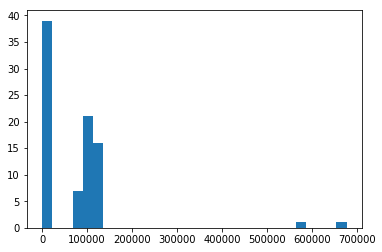

In [78]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.hist(azdias_NaN.isnull().sum(), bins=30)


In [79]:
# Investigate patterns in the amount of missing data in each column.



In [80]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

nanCounts = azdias_NaN.isnull().sum().values
nanIndices = azdias_NaN.isnull().sum().index

dropColumns = []

print("Outlier Missing Data Columns are:")
for i in range(len(nanCounts)):
    if nanCounts[i] > 300000:
        dropColumns.append(nanIndices[i])
        
print(dropColumns)

azdias_NaN = azdias_NaN.drop(dropColumns, axis=1)

Outlier Missing Data Columns are:
['AGER_TYP', 'KK_KUNDENTYP']


(array([ 27.,  11.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,
          0.,   6.,   3.,   4.,   3.,   0.,   1.,   1.,   3.,   0.,   7.,
          0.,   2.,   0.,   0.,   0.,   7.]),
 array([      0.  ,    2666.48,    5332.96,    7999.44,   10665.92,
          13332.4 ,   15998.88,   18665.36,   21331.84,   23998.32,
          26664.8 ,   29331.28,   31997.76,   34664.24,   37330.72,
          39997.2 ,   42663.68,   45330.16,   47996.64,   50663.12,
          53329.6 ,   55996.08,   58662.56,   61329.04,   63995.52,
          66662.  ,   69328.48,   71994.96,   74661.44,   77327.92,
          79994.4 ,   82660.88,   85327.36,   87993.84,   90660.32,
          93326.8 ,   95993.28,   98659.76,  101326.24,  103992.72,
         106659.2 ,  109325.68,  111992.16,  114658.64,  117325.12,
         119991.6 ,  122658.08,  125324.56,  1

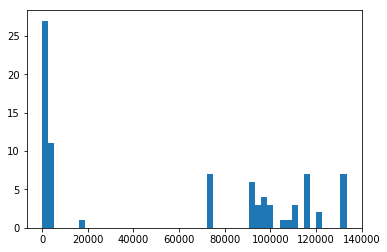

In [81]:
plt.hist(azdias_NaN.isnull().sum(), bins=50)

In [82]:
print(format(300000/891221 * 100, '.2f'))

33.66


#### Discussion 1.1.2: Assess Missing Data in Each Column

Most columns (around 45 of them) with missing data seem to revolve around 100,000 missing data points. There are a few columns (around 2-3) with missing data in the 600k-700k range that seem to be outliers to the rest of the columns.

**Final Decision:** Remove columns greater than 300k missing data. (34% of a dataset)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [83]:
print(azdias_NaN.shape)

(891221, 83)


(array([  6.91823000e+05,   4.70160000e+04,   4.10300000e+03,
          1.02400000e+03,   1.55730000e+04,   1.71560000e+04,
          5.27200000e+03,   1.50800000e+03,   3.33700000e+03,
          2.08300000e+03,   6.63300000e+03,   6.25000000e+02,
          1.60900000e+03,   8.60000000e+01,   1.06000000e+02,
          4.60000000e+01,   3.40000000e+01,   2.20000000e+01,
          3.00000000e+00,   1.20000000e+01,   0.00000000e+00,
          1.82130000e+04,   3.99000000e+02,   8.59000000e+02,
          8.00000000e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   7.35960000e+04,   3.00000000e+00]),
 array([  0.        ,   1.56666667,   3.13333333,   4.7       ,
          6.26666667,   7.83333333,   9.4       ,  10.96666667,
         12.53333333,  14.1       ,  15.66666667,  17.23333333,
         18.8       ,  20.36666667,  21.93333333,  23.5       ,
         25.06666667,  26.63333333,  28.2       ,  29.76666667,
         31.33333333,  32.9       ,  34.46666667,  36.0333

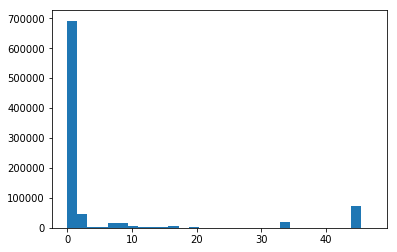

In [84]:
# How much data is missing in each row of the dataset?

azdiasRow_NAN = azdias_NaN.isnull().sum(axis=1)

plt.hist(azdiasRow_NAN, bins=30)

In [85]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# azdiasRow_less25 = azdiasRow_NAN.where(azdiasRow_NAN <= 25)
# azdiasRow_more25 = azdiasRow_NAN.where(azdiasRow_NAN > 25)

azdiasRow_less25 = azdiasRow_NAN[azdiasRow_NAN <= 25]
azdiasRow_more25 = azdiasRow_NAN[azdiasRow_NAN > 25]

azdias_less25 = azdias_NaN.drop(azdiasRow_more25.index)
azdias_more25 = azdias_NaN.drop(azdiasRow_less25.index)

print(azdias_less25.shape)
print(azdias_more25.shape)

(798000, 83)
(93221, 83)


In [86]:
outClustCount_gen = azdias_more25.shape[0]

(array([  6.65058000e+05,   2.67650000e+04,   9.79400000e+03,
          3.72220000e+04,   4.10300000e+03,   0.00000000e+00,
          6.41000000e+02,   3.83000000e+02,   1.55730000e+04,
          5.37300000e+03,   1.17830000e+04,   0.00000000e+00,
          5.27200000e+03,   8.78000000e+02,   6.30000000e+02,
          3.96000000e+02,   2.94100000e+03,   0.00000000e+00,
          2.08300000e+03,   4.33300000e+03,   2.30000000e+03,
          6.25000000e+02,   4.16000000e+02,   0.00000000e+00,
          1.19300000e+03,   8.60000000e+01,   5.10000000e+01,
          5.50000000e+01,   3.30000000e+01,   1.30000000e+01]),
 array([  0.        ,   0.83333333,   1.66666667,   2.5       ,
          3.33333333,   4.16666667,   5.        ,   5.83333333,
          6.66666667,   7.5       ,   8.33333333,   9.16666667,
         10.        ,  10.83333333,  11.66666667,  12.5       ,
         13.33333333,  14.16666667,  15.        ,  15.83333333,
         16.66666667,  17.5       ,  18.33333333,  19.1666

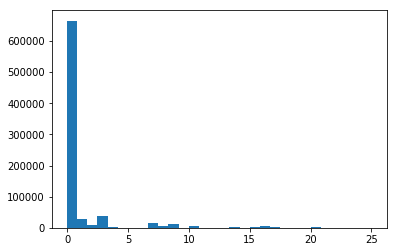

In [87]:
plt.hist(azdias_less25.isnull().sum(axis=1), bins=30)

In [88]:
# Determine 8 columns with no missing values
noMissCols = []

for index, row in feat_info.iterrows():
    if row['attribute'] in azdias_NaN.columns:
        nancount = azdias_NaN[row['attribute']].isnull().sum()

        if nancount < 5:
            noMissCols.append(row['attribute'])

            if len(noMissCols) == 8:
                break

print(noMissCols)

['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP']


In [89]:
def plotFeature(fName):
    '''
    This function plots the distribution of values for a particular feature for both datasets
    
    INPUT: fName - Name of Feature (no or few missing values)
    OUTPUT: Two figures with the distribution of values for the feature
    '''
    fig, ax =plt.subplots(1,2)
    sns.countplot(azdias_less25[fName], ax=ax[0])
    sns.countplot(azdias_more25[fName], ax=ax[1])
    fig.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


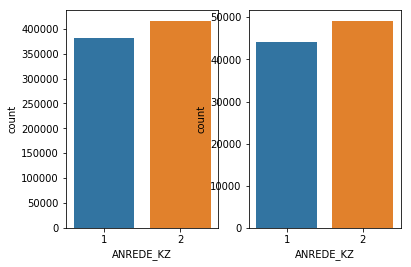

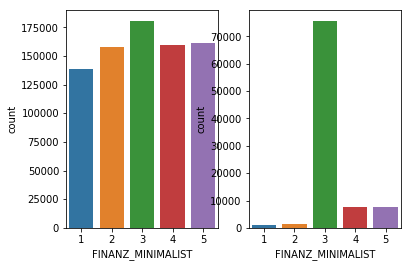

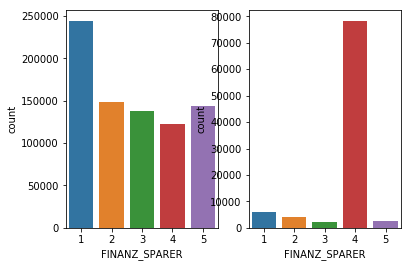

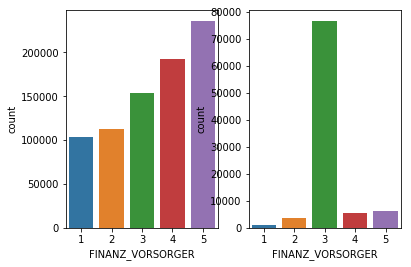

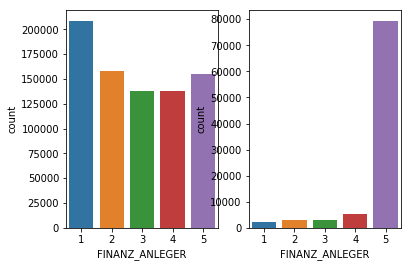

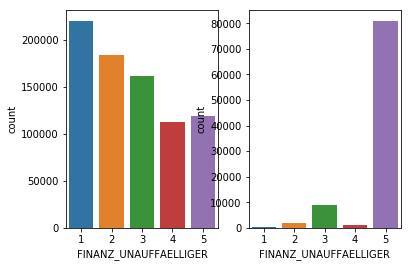

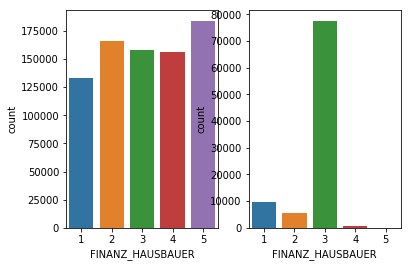

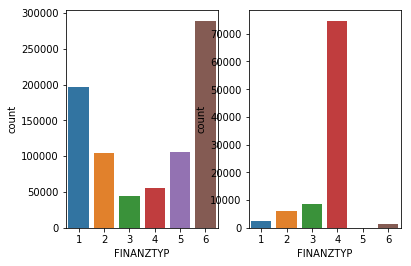

In [90]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

for colName in range(len(noMissCols)):
    plotFeature(noMissCols[colName])

#### Discussion 1.1.3: Assess Missing Data in Each Row

The data with more than 25 missing features has a heavily skewed distribution in features with no missing data. Although we will continue the analysis with "less than 25 missing features", we should treat this as a separate cluster at the time of our clustering analysis.

Therefore, we should **treat the "more than 25 missing features" dataset as special, and do not discard completely**.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [91]:
# How many features are there of each data type?

print(feat_info['type'].value_counts())

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [92]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

multiCat_Cols = []

for index, row in feat_info.iterrows():
    if row['attribute'] in azdias_less25 and row['type'] == "categorical":
        uniqueSeries = azdias_less25[row['attribute']].unique()
        nanAdj = 1 if azdias_less25[row['attribute']].isnull().sum() > 0 else 0
        
        print(row['attribute'])
        print("Unique values: " + str(len(azdias_less25[row['attribute']].value_counts())))
        print("# of NaN: " + str(nanAdj))
        print(uniqueSeries)
        print("----------")
        
        if (len(uniqueSeries) - nanAdj) >= 3:
            multiCat_Cols.append(row['attribute'])
            
print("Multi-level Categorical Variables:")
print(multiCat_Cols)

ANREDE_KZ
Unique values: 2
# of NaN: 0
[2 1]
----------
CJT_GESAMTTYP
Unique values: 6
# of NaN: 1
[  5.   3.   2.   4.   1.   6.  nan]
----------
FINANZTYP
Unique values: 6
# of NaN: 0
[1 6 5 2 4 3]
----------
GFK_URLAUBERTYP
Unique values: 12
# of NaN: 1
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
----------
GREEN_AVANTGARDE
Unique values: 2
# of NaN: 0
[0 1]
----------
LP_FAMILIE_FEIN
Unique values: 12
# of NaN: 1
[  5.   1.   0.  10.   2.   7.  11.   8.   4.   6.  nan   9.   3.]
----------
LP_FAMILIE_GROB
Unique values: 6
# of NaN: 1
[  3.   1.   0.   5.   2.   4.  nan]
----------
LP_STATUS_FEIN
Unique values: 10
# of NaN: 1
[  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
----------
LP_STATUS_GROB
Unique values: 5
# of NaN: 1
[  1.   2.   4.   5.   3.  nan]
----------
NATIONALITAET_KZ
Unique values: 4
# of NaN: 0
[1 3 2 0]
----------
SHOPPER_TYP
Unique values: 4
# of NaN: 1
[  3.   2.   1.   0.  nan]
----------
SOHO_KZ
Unique values: 2
# of NaN: 0
[ 

In [93]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_proc = pd.DataFrame(data=azdias_less25)

# Re-encode binary string categorial variable
azdias_proc['OST_WEST_KZ'] = azdias_proc['OST_WEST_KZ'].map({'W': 1, 'O': 2})
print("OST_WEST_KZ replaced.")
print(azdias_proc['OST_WEST_KZ'].unique())

# Identify categories to drop
multiCat_Cols_DROP = ["LP_FAMILIE_FEIN", "LP_STATUS_FEIN", "NATIONALITAET_KZ", "TITEL_KZ", "ZABEOTYP", "CAMEO_DEU_2015"]

# Re-encode multi-level categorical variables
for j in range(len(multiCat_Cols)):
    if not multiCat_Cols[j] in multiCat_Cols_DROP:
        # One Hot Encode
        azdias_proc = pd.concat([azdias_proc, pd.get_dummies(azdias_proc[multiCat_Cols[j]], prefix=multiCat_Cols[j])], axis=1)
        
# Drop other multi-level categorical variables
azdias_proc.drop(multiCat_Cols_DROP, axis=1, inplace=True)

print(azdias_proc.shape)

OST_WEST_KZ replaced.
[1 2]
(798000, 132)


#### Discussion 1.2.1: Re-Encode Categorical Features

**Binary Non-Numeric Variable:**  
Identified "OST_WEST_KZ" as the binary non-numeric variable. This was re-encoded using an arbitrary numeric system (W = 1, O = 2)

**Multi-level Categorical Variables:**
1. CJT_GESAMTTYP  
Customer-Journey-Typology: preferred information and buying channels for consumer.  
**Keep** This contains data on their channel preferences, crucial to determine a customer base for mail orders.


2. FINANZTYP  
Most descriptive financial type for individual  
**Keep** Will describe their spending habits/views, so moderately descriptive of their propensity to spend via mail-order.


3. GFK_URLAUBERTYP  
Vacation habits  
**Keep** Depends on the type of good/service advertised by the mail-order (e.g. ski sales right before ski season), but probably worth keeping.


4. LP_FAMILIE_FEIN  
Family type, fine scale  
**Drop** Probably not a whole lot more insightful than LP_FAMILIE_GROB, which is the same data at a rougher scale.


5. LP_FAMILIE_GROB  
Family type, rough scale  
**Keep** Yes, it's key demographic data that implies spending habits.


6. LP_STATUS_FEIN  
Social status, fine scale  
**Drop** If certain segments of this categorization is helpful for the client's product/service, yes. But at a high level, probably more info than we need (Similar to LP_FAMILIE_FEIN - #4 above)


7. LP_STATUS_GROB  
Social status, rough scale  
**Keep** Yes, social demographics is a strong predictor for propensity to spend.


8. NATIONALITAET_KZ  
Nationality based on given name analysis  
**Drop** Probably not too much, as for most goods/services, factors other than nationality are way stronger predictors for spending preferences.


9. SHOPPER_TYP  
Shopper typology  
**Keep** Yes, as it describes in greater detail the spending patterns of the lead.


10. TITEL_KZ  
Academic title flag  
**Drop** Not all that helpful for most goods/services.


11. ZABEOTYP  
Energy consumption typology  
**Drop** Only if the product is energy-related (e.g. smart thermometers, net meters, energy efficiency apps). As that doesn't seem to be the case for our client, drop.


12. GEBAEUDETYP  
Type of building (residential vs. commercial)  
**Keep** This will be helpful in determining what types of goods/services the customer would be interested in.


13. CAMEO_DEUG_2015  
German CAMEO: Wealth / Life Stage Typology, rough scale  
**Keep** Yes, as it is a socioeconomic demographic classification that contains detailed information on their propensity to spend.


14. CAMEO_DEU_2015  
German CAMEO: Wealth / Life Stage Typology, detailed scale  
**Drop** For general demographic segmentation like mail-order customers, this level of detail is not required (not worth the extra processing time/costs).

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [94]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Map of decade
def decadeMap(c):
    if 1 <= c['PRAEGENDE_JUGENDJAHRE'] <= 2:
        return 40
    elif 3 <= c['PRAEGENDE_JUGENDJAHRE'] <= 4:
        return 50
    elif 5 <= c['PRAEGENDE_JUGENDJAHRE'] <= 7:
        return 60
    elif 8 <= c['PRAEGENDE_JUGENDJAHRE'] <= 9:
        return 70
    elif 10 <= c['PRAEGENDE_JUGENDJAHRE'] <= 13:
        return 80
    elif 14 <= c['PRAEGENDE_JUGENDJAHRE']:
        return 90
    else:
        return np.nan

# Create Decade Column
azdias_proc['decade'] = azdias_proc.apply(decadeMap, axis=1)
print("decade feature generated. Unique values check:")
print(azdias_proc['decade'].unique())

# Map of movement
def movementMap(c):
    if c['PRAEGENDE_JUGENDJAHRE'] == 1 or c['PRAEGENDE_JUGENDJAHRE'] == 3 or c['PRAEGENDE_JUGENDJAHRE'] == 5 or c['PRAEGENDE_JUGENDJAHRE'] == 8 or c['PRAEGENDE_JUGENDJAHRE'] == 10 or c['PRAEGENDE_JUGENDJAHRE'] == 12 or c['PRAEGENDE_JUGENDJAHRE'] == 14:
        return 1
    elif c['PRAEGENDE_JUGENDJAHRE'] == 2 or c['PRAEGENDE_JUGENDJAHRE'] == 4 or c['PRAEGENDE_JUGENDJAHRE'] == 6 or c['PRAEGENDE_JUGENDJAHRE'] == 7 or c['PRAEGENDE_JUGENDJAHRE'] == 9 or c['PRAEGENDE_JUGENDJAHRE'] == 11 or c['PRAEGENDE_JUGENDJAHRE'] == 13 or c['PRAEGENDE_JUGENDJAHRE'] == 15:
        return 2
    else:
        return np.nan

# Create Decade Column
azdias_proc['movement'] = azdias_proc.apply(movementMap, axis=1)
print("movement feature generated. Unique values check:")
print(azdias_proc['movement'].unique())

print(azdias_proc.shape)

decade feature generated. Unique values check:
[ 90.  70.  50.  80.  60.  nan  40.]
movement feature generated. Unique values check:
[  1.   2.  nan]
(798000, 134)


In [95]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
import math

# Map of Wealth
def wealthMap(c):
    finalParam = np.int64(c['CAMEO_INTL_2015']) if type(c['CAMEO_INTL_2015']) is str else c['CAMEO_INTL_2015']
    
    if c['CAMEO_INTL_2015'] == np.nan or math.isnan(finalParam):
        return np.nan
    elif 10 <= finalParam < 20:
        return 1
    elif 20 <= finalParam < 30:
        return 2
    elif 30 <= finalParam < 40:
        return 3
    elif 40 <= finalParam < 50:
        return 4
    elif 50 <= finalParam < 60:
        return 5
    
azdias_proc['wealth'] = azdias_proc.apply(wealthMap, axis=1)

print("wealth feature generated. Unique values check:")
print(azdias_proc['wealth'].unique())

def lifestageMap(c):
    finalParam = np.int64(c['CAMEO_INTL_2015']) if type(c['CAMEO_INTL_2015']) is str else c['CAMEO_INTL_2015']
    
    if c['CAMEO_INTL_2015'] == np.nan or math.isnan(finalParam):
        return np.nan
    elif 10 <= finalParam < 60:
        return (finalParam % 10)
    
azdias_proc['lifestage'] = azdias_proc.apply(lifestageMap, axis=1)

print("lifestage feature generated. Unique values check:")
print(azdias_proc['lifestage'].unique())

wealth feature generated. Unique values check:
[  5.   2.   1.   4.   3.  nan]
lifestage feature generated. Unique values check:
[  1.   4.   2.   3.   5.  nan]


In [96]:
azdias_proc.drop(["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"], axis=1, inplace=True)

print(azdias_proc.shape)

(798000, 134)


In [97]:
# Scan through remaining mixed variables
mixed_Cols = []

for index, row in feat_info.iterrows():
    if row['attribute'] in azdias_proc and row['type'] == "mixed" and row['attribute'] != "PRAEGENDE_JUGENDJAHRE" and row['attribute'] != "CAMEO_INTL_2015":
        mixed_Cols.append(row['attribute'])
            
print("Remaining Mixed Categorical Variables:")
print(mixed_Cols)

# Drop all other mixed variables (see discussion below)
azdias_proc.drop(mixed_Cols, axis=1, inplace=True)

Remaining Mixed Categorical Variables:
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']


In [98]:
print(azdias_proc.shape)

(798000, 129)


#### Discussion 1.2.2: Engineer Mixed-Type Features

##### Key Transformations
1. PRAEGENDE_JUGENDJAHRE - Split into decade & movement based on values (mapped decade using the string answers in the DataDictionary, corresponding to decades, and set "movement" on an arbitrary, binary number value - Avantgarde = 2, Mainstream = 1)
2. CAMEO_INTL_2015 - Split into wealth (i.e. the scale indicated in DataDictionary - higher = poorer) & life stage (mapped second digit to corresponding lifestage group)

##### Others
1. LP_LEBENSPHASE_FEIN  
Life stage, fine scale  
**Drop** Life stage detail already extracted from CAMEO_INTL_2015 (named "lifestage"). Furthermore, this categorization is far more detailed than we need.


2. CAMEO_INTL_2015  
Life stage, rough scale  
**Drop** Won't hurt keeping, but probably not much incremental value over the extracted "lifestage".


3. WOHNLAGE  
Neighborhood quality (or rural flag)  
**Drop** Won't hurt keeping, but probably not much incremental value over the extracted "wealth".


4. KBA05_BAUMAX  
Most common building type within the microcell  
**Drop** Probably not much useful info in analyzing an individual consumer.


4. PLZ8_BAUMAX  
Most common building type within the PLZ8 region  
**Drop** Probably not much useful info in analyzing an individual consumer.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Preprocessing Summary
1. Convert all missing values to "NaN" (according to feat_info's mapping (in column 4)  
2. Remove outlier columns (threshold >= 500k missing)  
3. Remove outlier rows (threshold > 25 missing), after checking same data distribution for non-missing features  
4. En-coding (Categorical)  
    **OST_WEST_KZ** - Convert to binary numerical variable (W = 1, S = 2)  
    **Re-encoded Variables** = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']  
    **Drop Variables** - ["LP_FAMILIE_FEIN", "LP_STATUS_FEIN", "NATIONALITAET_KZ", "TITEL_KZ", "ZABEOTYP", "CAMEO_DEU_2015"]  
5. En-coding (Mixed)  
    **PRAEGENDE_JUGENDJAHRE** - Split into (1) decade, and (2) movement  
    **CAMEO_INTL_2015** - Split into (1) wealth, and (2) lifestage  
    **Drop Variables** - ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']  
    
### QC List
1. For each column, check that there are no values with the original "missing data" values (feat_info, col 4) - they must all be NaNs
2. Check that appropiate columns have been removed & added - **Done**
3. Check that rows are properly isolating the outliers - **Done**
4. Check data types & values of encoded columns
5. Check data types & values of columns created from the "mixed" data

**Drop Columns:**  
[The 2 Outliers]  
LP_FAMILIE_FEIN  
LP_STATUS_FEIN  
NATIONALITAET_KZ  
TITEL_KZ  
ZABEOTYP  
CAMEO_DEU_2015  
PRAEGENDE_JUGENDJAHRE  
CAMEO_INTL_2015  
LP_LEBENSPHASE_FEIN  
LP_LEBENSPHASE_GROB  
WOHNLAGE  
KBA05_BAUMAX  
PLZ8_BAUMAX  

In [99]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [100]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

reencodedDrops = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']

azdias_proc.drop(reencodedDrops, axis=1, inplace=True)

# Check Column Names
print(azdias_proc.columns.values)

['ALTERSKATEGORIE_GROB' 'ANREDE_KZ' 'FINANZ_MINIMALIST' 'FINANZ_SPARER'
 'FINANZ_VORSORGER' 'FINANZ_ANLEGER' 'FINANZ_UNAUFFAELLIGER'
 'FINANZ_HAUSBAUER' 'GEBURTSJAHR' 'GREEN_AVANTGARDE' 'HEALTH_TYP'
 'RETOURTYP_BK_S' 'SEMIO_SOZ' 'SEMIO_FAM' 'SEMIO_REL' 'SEMIO_MAT'
 'SEMIO_VERT' 'SEMIO_LUST' 'SEMIO_ERL' 'SEMIO_KULT' 'SEMIO_RAT'
 'SEMIO_KRIT' 'SEMIO_DOM' 'SEMIO_KAEM' 'SEMIO_PFLICHT' 'SEMIO_TRADV'
 'SOHO_KZ' 'VERS_TYP' 'ALTER_HH' 'ANZ_PERSONEN' 'ANZ_TITEL'
 'HH_EINKOMMEN_SCORE' 'W_KEIT_KIND_HH' 'WOHNDAUER_2008'
 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'KONSUMNAEHE' 'MIN_GEBAEUDEJAHR'
 'OST_WEST_KZ' 'KBA05_ANTG1' 'KBA05_ANTG2' 'KBA05_ANTG3' 'KBA05_ANTG4'
 'KBA05_GBZ' 'BALLRAUM' 'EWDICHTE' 'INNENSTADT' 'GEBAEUDETYP_RASTER' 'KKK'
 'MOBI_REGIO' 'ONLINE_AFFINITAET' 'REGIOTYP' 'KBA13_ANZAHL_PKW'
 'PLZ8_ANTG1' 'PLZ8_ANTG2' 'PLZ8_ANTG3' 'PLZ8_ANTG4' 'PLZ8_HHZ' 'PLZ8_GBZ'
 'ARBEIT' 'ORTSGR_KLS9' 'RELAT_AB' 'CJT_GESAMTTYP_1.0' 'CJT_GESAMTTYP_2.0'
 'CJT_GESAMTTYP_3.0' 'CJT_GESAMTTYP_4.0' 'CJT_GESAMTTYP

In [101]:
print(azdias_proc.shape)

(798000, 121)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [102]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    import math
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_NaN = pd.DataFrame(data=df)
    
    for index, row in feat_info.iterrows():
        strArr = row['missing_or_unknown'][1:-1].split(",")

        for index2 in range(len(strArr)):
            finalID = strArr[index2]

            if finalID == "":
                finalID = False
            elif finalID != "X" and finalID != "XX":
                finalID = np.float64(finalID)

            if finalID:
                df_NaN[row['attribute']] = df_NaN[row['attribute']].replace(finalID, np.nan)

    print("NaN Conversion Done!")
    
    plt.hist(df_NaN.isnull().sum(), bins=30)
    plt.show()
    
    # remove selected columns and rows, ...
    # Remove outlier columns
    nanCounts = df_NaN.isnull().sum().values
    nanIndices = df_NaN.isnull().sum().index

    dropColumns = []

    print("Outlier Missing Data Columns are:")
    for i in range(len(nanCounts)):
        if nanCounts[i] > round(0.3 * df_NaN.shape[0]):
            dropColumns.append(nanIndices[i])
    
    print(dropColumns)

    df_NaN = df_NaN.drop(dropColumns, axis=1)
    
    print("Outlier columns removed. Shape is:")
    print(df_NaN.shape)
    
    # Remove outlier rows
    dfRow_NAN = df_NaN.isnull().sum(axis=1)

    plt.hist(dfRow_NAN, bins=30)
    
    dfRow_less25 = dfRow_NAN[dfRow_NAN <= 25]
    dfRow_more25 = dfRow_NAN[dfRow_NAN > 25]

    df_less25 = df_NaN.drop(dfRow_more25.index)
    df_more25 = df_NaN.drop(dfRow_less25.index)
    
    print("Outlier rows removed. Shape is:")
    print(df_less25.shape)
    
    # select, re-encode, and engineer column values.
    # Re-encode Categorical Variables
    multiCat_Cols = []

    for index, row in feat_info.iterrows():
        if row['attribute'] in df_less25 and row['type'] == "categorical":
            uniqueSeries = df_less25[row['attribute']].unique()
            nanAdj = 1 if df_less25[row['attribute']].isnull().sum() > 0 else 0

            if (len(uniqueSeries) - nanAdj) >= 3:
                multiCat_Cols.append(row['attribute'])
    
    df_proc = pd.DataFrame(data=df_less25)
    
    df_proc['OST_WEST_KZ'] = df_proc['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    print("OST_WEST_KZ replaced.")
    
    multiCat_Cols_DROP = ["LP_FAMILIE_FEIN", "LP_STATUS_FEIN", "NATIONALITAET_KZ", "TITEL_KZ", "ZABEOTYP", "CAMEO_DEU_2015"]
    
    for j in range(len(multiCat_Cols)):
        if not multiCat_Cols[j] in multiCat_Cols_DROP:
            # One Hot Encode
            df_proc = pd.concat([df_proc, pd.get_dummies(df_proc[multiCat_Cols[j]], prefix=multiCat_Cols[j])], axis=1)
      
    # Add Missing Column (GEBAEUDETYP_5.0)
    df_proc['GEBAEUDETYP_5.0'] = 0
    
#     print(df_proc.columns.values)
    
    df_proc.drop(multiCat_Cols_DROP, axis=1, inplace=True)
    
    reencodedDrops = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'SHOPPER_TYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']

    df_proc.drop(reencodedDrops, axis=1, inplace=True)

    print("Categorical variables processed. New shape is:")
    print(df_proc.shape)
    
    # Re-encode Multi variables
    # PRAEGENDE_JUGENDJAHRE
    def decadeMap(c):
        if 1 <= c['PRAEGENDE_JUGENDJAHRE'] <= 2:
            return 40
        elif 3 <= c['PRAEGENDE_JUGENDJAHRE'] <= 4:
            return 50
        elif 5 <= c['PRAEGENDE_JUGENDJAHRE'] <= 7:
            return 60
        elif 8 <= c['PRAEGENDE_JUGENDJAHRE'] <= 9:
            return 70
        elif 10 <= c['PRAEGENDE_JUGENDJAHRE'] <= 13:
            return 80
        elif 14 <= c['PRAEGENDE_JUGENDJAHRE']:
            return 90
        else:
            return np.nan
    
    df_proc['decade'] = df_proc.apply(decadeMap, axis=1)
    print("decade feature generated.")
    
    def movementMap(c):
        if c['PRAEGENDE_JUGENDJAHRE'] == 1 or c['PRAEGENDE_JUGENDJAHRE'] == 3 or c['PRAEGENDE_JUGENDJAHRE'] == 5 or c['PRAEGENDE_JUGENDJAHRE'] == 8 or c['PRAEGENDE_JUGENDJAHRE'] == 10 or c['PRAEGENDE_JUGENDJAHRE'] == 12 or c['PRAEGENDE_JUGENDJAHRE'] == 14:
            return 1
        elif c['PRAEGENDE_JUGENDJAHRE'] == 2 or c['PRAEGENDE_JUGENDJAHRE'] == 4 or c['PRAEGENDE_JUGENDJAHRE'] == 6 or c['PRAEGENDE_JUGENDJAHRE'] == 7 or c['PRAEGENDE_JUGENDJAHRE'] == 9 or c['PRAEGENDE_JUGENDJAHRE'] == 11 or c['PRAEGENDE_JUGENDJAHRE'] == 13 or c['PRAEGENDE_JUGENDJAHRE'] == 15:
            return 2
        else:
            return np.nan
    
    df_proc['movement'] = df_proc.apply(movementMap, axis=1)
    print("movement feature generated.")
    
    # CAMEO_INTL_2015
    def wealthMap(c):
        finalParam = np.int64(c['CAMEO_INTL_2015']) if type(c['CAMEO_INTL_2015']) is str else c['CAMEO_INTL_2015']

        if c['CAMEO_INTL_2015'] == np.nan or math.isnan(finalParam):
            return np.nan
        elif 10 <= finalParam < 20:
            return 1
        elif 20 <= finalParam < 30:
            return 2
        elif 30 <= finalParam < 40:
            return 3
        elif 40 <= finalParam < 50:
            return 4
        elif 50 <= finalParam < 60:
            return 5

    df_proc['wealth'] = df_proc.apply(wealthMap, axis=1)

    print("wealth feature generated.")

    def lifestageMap(c):
        finalParam = np.int64(c['CAMEO_INTL_2015']) if type(c['CAMEO_INTL_2015']) is str else c['CAMEO_INTL_2015']

        if c['CAMEO_INTL_2015'] == np.nan or math.isnan(finalParam):
            return np.nan
        elif 10 <= finalParam < 60:
            return (finalParam % 10)

    df_proc['lifestage'] = df_proc.apply(lifestageMap, axis=1)

    print("lifestage feature generated.")
    
    df_proc.drop(["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"], axis=1, inplace=True)
    
    mixed_Cols = []
    for index, row in feat_info.iterrows():
        if row['attribute'] in df_proc and row['type'] == "mixed" and row['attribute'] != "PRAEGENDE_JUGENDJAHRE" and row['attribute'] != "CAMEO_INTL_2015":
            mixed_Cols.append(row['attribute'])

    print("Dropping Mixed Categorical Variables:")
    print(mixed_Cols)
    
    df_proc.drop(mixed_Cols, axis=1, inplace=True)
    
    print("Mixed variables processed. New shape is:")
    print(df_proc.shape)
    
    # Return the cleaned dataframe.
    df_proc = df_proc.astype(np.float64)

    df_proc = df_proc.fillna(df_proc.mean())
    
    print(np.any(np.isnan(azdias_fin)))

    print(np.all(np.isfinite(azdias_fin)))
    
    return df_proc

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [103]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_fin = azdias_proc.astype(np.float64)

azdias_fin = azdias_fin.fillna(azdias_fin.mean())

In [104]:
# Check for NaN or Infinite values (causes errors for StandardScaler)
for col in azdias_fin:
    if azdias_fin[col].isnull().sum() > 0:
        print(col)
        print(azdias_fin[col].describe())
        print(azdias_fin[col].unique())
        print('data type:')
        print(azdias_fin[col].dtypes)
        print(azdias_fin[col].head())
        print("----------------")
    
# azdias_fin.drop(["FINANZTYP", "KONSUMNAEHE", "REGIOTYP" ], axis=1, inplace=True)

print(np.any(np.isnan(azdias_fin)))

print(np.all(np.isfinite(azdias_fin)))

False
True


In [105]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_ss = ss.fit_transform(azdias_fin) # Fit and transform the data

# df_ss = pd.DataFrame(df_ss) #create a dataframe
# df_ss.columns = ['height', 'weight'] #add column names again

### Discussion 2.1: Apply Feature Scaling

When pre-processing the NaNs before scaling it via StandardScaler, I decided to **fill the missing values (the "NaN"s) with the mean of that column**. This should be an appropiate treatment because compared to the dataset (79,800 people), the number of people with more than 5 missing data points is miniscule. As we are using more than half the features in our modelling, using the average for these few missing data points would yield conservative predictions.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [106]:
from sklearn.decomposition import PCA

def do_pca(n_components, X):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
#     X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [107]:
# Apply PCA to the data.
pca, X_pca = do_pca(100, X_ss)

In [108]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

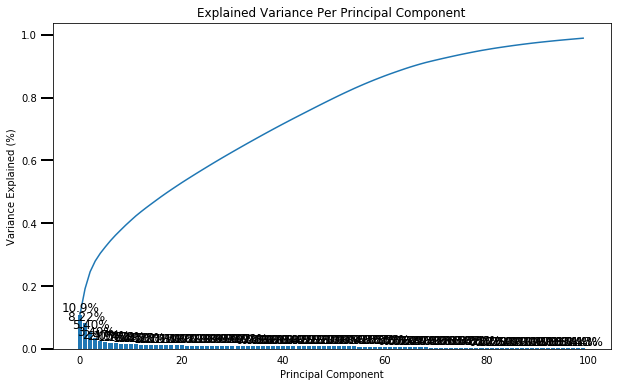

In [109]:
# Investigate the variance accounted for by each principal component.

scree_plot(pca)

In [110]:
# Re-apply PCA to the data while selecting for number of components to retain.

pcaF, X_pcaF = do_pca(75, X_ss)

### Discussion 2.2: Perform Dimensionality Reduction

Based on the scree plot, the cumulative variance reaches a bit above 90% with a principal component of around 75. Thus, I decided to retain **75 principal components for the next step of the analysis**.

The performance gains from the dimensionality reduction is clearly evident here, with the number of features reduced from 121 to 75 (~38% reduction), which could probably be improved with further iterations.

It's also noteworthy that the first 3 features account for around 25% of the cumulative variance, and will prove instrumental in training the model. Naturally, it would be crucial to try minimize the number of missing data of features that heavily influence these principal components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [111]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

import operator
import pprint

def pca_results(full_dataset, pca, pcaNo):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    
#     Create list of features, mapped to PCA's weights
    featureDict = dict(zip(full_dataset.keys(), np.round(pca.components_[pcaNo], 4)))
#     print(featureDict)
    
#     Sort features list
#     featureDict = sorted(featureDict.values())
    featureDict = sorted(featureDict.items(), key=operator.itemgetter(1))
    
    pprint.pprint(featureDict)

In [112]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_fin, pcaF, 0)

[('MOBI_REGIO', -0.21970000000000001),
 ('FINANZ_MINIMALIST', -0.20569999999999999),
 ('KBA05_ANTG1', -0.20519999999999999),
 ('PLZ8_ANTG1', -0.19919999999999999),
 ('KBA05_GBZ', -0.1958),
 ('KONSUMNAEHE', -0.14949999999999999),
 ('PLZ8_GBZ', -0.1462),
 ('INNENSTADT', -0.14199999999999999),
 ('LP_STATUS_GROB_4.0', -0.11990000000000001),
 ('lifestage', -0.1172),
 ('LP_STATUS_GROB_5.0', -0.1171),
 ('BALLRAUM', -0.1087),
 ('GEBAEUDETYP_RASTER', -0.107),
 ('GREEN_AVANTGARDE', -0.1056),
 ('movement', -0.1032),
 ('ALTERSKATEGORIE_GROB', -0.0998),
 ('FINANZ_VORSORGER', -0.097600000000000006),
 ('GEBAEUDETYP_1.0', -0.0974),
 ('CAMEO_DEUG_2015_2', -0.092799999999999994),
 ('FINANZTYP_2', -0.089300000000000004),
 ('ANZ_PERSONEN', -0.079500000000000001),
 ('CAMEO_DEUG_2015_4', -0.076499999999999999),
 ('CAMEO_DEUG_2015_3', -0.069199999999999998),
 ('KBA13_ANZAHL_PKW', -0.067100000000000007),
 ('LP_FAMILIE_GROB_5.0', -0.060999999999999999),
 ('SEMIO_LUST', -0.059700000000000003),
 ('SEMIO_ERL', -0

In [113]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias_fin, pcaF, 1)

[('decade', -0.247),
 ('FINANZ_SPARER', -0.23119999999999999),
 ('SEMIO_REL', -0.22770000000000001),
 ('FINANZ_UNAUFFAELLIGER', -0.22309999999999999),
 ('SEMIO_TRADV', -0.21410000000000001),
 ('SEMIO_PFLICHT', -0.21290000000000001),
 ('FINANZ_ANLEGER', -0.2049),
 ('SEMIO_KULT', -0.1827),
 ('ONLINE_AFFINITAET', -0.1694),
 ('SEMIO_RAT', -0.1691),
 ('SEMIO_FAM', -0.151),
 ('SEMIO_MAT', -0.1429),
 ('FINANZTYP_1', -0.12659999999999999),
 ('ALTER_HH', -0.10100000000000001),
 ('FINANZTYP_4', -0.096100000000000005),
 ('FINANZTYP_3', -0.086599999999999996),
 ('PLZ8_ANTG1', -0.077399999999999997),
 ('SEMIO_SOZ', -0.0751),
 ('MOBI_REGIO', -0.0751),
 ('KBA05_GBZ', -0.074200000000000002),
 ('GFK_URLAUBERTYP_9.0', -0.073999999999999996),
 ('LP_FAMILIE_GROB_4.0', -0.0688),
 ('KBA05_ANTG1', -0.066299999999999998),
 ('ANZ_PERSONEN', -0.066000000000000003),
 ('INNENSTADT', -0.061600000000000002),
 ('PLZ8_GBZ', -0.0613),
 ('KONSUMNAEHE', -0.061100000000000002),
 ('CJT_GESAMTTYP_4.0', -0.06110000000000000

In [114]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias_fin, pcaF, 2)

[('ANREDE_KZ', -0.35849999999999999),
 ('SEMIO_KAEM', -0.33129999999999998),
 ('SEMIO_DOM', -0.30330000000000001),
 ('SEMIO_KRIT', -0.2732),
 ('SEMIO_ERL', -0.2006),
 ('SEMIO_RAT', -0.1799),
 ('FINANZ_ANLEGER', -0.1603),
 ('FINANZTYP_1', -0.11119999999999999),
 ('SHOPPER_TYP_2.0', -0.099099999999999994),
 ('FINANZ_SPARER', -0.073099999999999998),
 ('decade', -0.072900000000000006),
 ('FINANZ_UNAUFFAELLIGER', -0.068000000000000005),
 ('SHOPPER_TYP_3.0', -0.051799999999999999),
 ('LP_FAMILIE_GROB_3.0', -0.050299999999999997),
 ('FINANZ_HAUSBAUER', -0.049000000000000002),
 ('SEMIO_PFLICHT', -0.043499999999999997),
 ('INNENSTADT', -0.041599999999999998),
 ('PLZ8_ANTG1', -0.041500000000000002),
 ('SEMIO_TRADV', -0.0407),
 ('ONLINE_AFFINITAET', -0.037999999999999999),
 ('KONSUMNAEHE', -0.0373),
 ('CJT_GESAMTTYP_6.0', -0.036999999999999998),
 ('BALLRAUM', -0.034700000000000002),
 ('PLZ8_GBZ', -0.033799999999999997),
 ('GEBAEUDETYP_RASTER', -0.033000000000000002),
 ('GFK_URLAUBERTYP_9.0', -0.0

### Discussion 2.3: Interpret Principal Components

### 1. First PC
**Top negative:**  
- MOBI_REGIO - Movement patterns (higher = lower movement)
- FINANZ_MINIMALIST - Financial typology, for each dimension - lower financial interest (higher = lower chances)
- KBA05_ANTG1 - Number of 1-2 family houses in the microcell (higher = higher share of 1-2 family homes)
- PLZ8_ANTG1 - Number of 1-2 family houses in the PLZ8 region (higher = higher share of 1-2 family homes)
- KBA05_GBZ - Number of buildings in the microcell (higher = more buildings) 

**Top positive:**  
- LP_STATUS_GROB_1.0 - Social status, rough scale (1 = low income, higher = more chance of poor)
- PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region (higher = higher share of 6-10 family homes)
- wealth - (higher = poorer)
- HH_EINKOMMEN_SCORE - Estimated household net income (higher = lower income)
- PLZ8_ANTG4 - Number of 10+ family houses in the PLZ8 region (higher = higher share of 10+ family homes)

**Conclusion**
This PCA seems to be one that indicates a combination of economic status and density of family homes in the area of interest. Negative values indicate areas with a high share of 1-2 family homes (less densely populated), whereas positive values indicate poorer consumers in regions with higher densities of family homes. The former segment is more prone to mail order as they are in areas where stores are less accessible than densely populated areas, and are more likely to have more economic power (translating into spending).

### 2. Second PC
**Top negative:**  
- decade: Higher values indicate younger people (i.e. dominating movement of youth)  
- FINANZ_SPARER: The money-spending tendencies (higher = lower tendency to save)  
- SEMIO_REL: Religious scale (higher = lower religious affinity)  
- FINANZ_UNAUFFAELLIGER: Inconspicuous spending tendencies (higher = flashier spending)  
- SEMIO_TRADV: Tradition-minded (higher = lower affinity for tradition)  
- SEMIO_PFLICHT: Dutifulness (higher = less sense of duty)  

**Top positive:**  
- ALTERSKATEGORIE_GROB: Higher = older  
- FINANZ_VORSORGER: Preparedness (Higher = lower)  
- SEMIO_ERL: event-oriented (higher = lower affinity)  
- SEMIO_LUST: dreamful (higher = less dreamful)  
- RETOURTYP_BK_S: determined Minimal-Returner (higher = bigger saver)  
- W_KEIT_KIND_HH likelihood of children in household (higher = unlikely)  

**Conclusion**
At a high level, this principal component seems to indicate demographics for consumer types, centered on age. The negative features collectively trend toward younger people who tend to be higher, flashier spenders with little that holds them back (e.g. tradition, religion, dutifulness), whereas the positive features describe older consumers - who tend to be big savers, and tend to lead a mundane, low-key spending style (not event-oriented, not too dreamful).

This clearly seems like a major indicator to predicting core customers for our client's mail-order campaigns.

### 3. Third PC
**Top negative:**  
- ANREDE_KZ: Gender (higher = female)  
- SEMIO_KAEM: Combative attitude (higher = lower)  
- SEMIO_DOM: Dominant-minded (higher = lower)  
- SEMIO_KRIT: Critical-minded (higher = lower)  
- SEMIO_ERL: Event-oriented (higher = lower)  

**Top positive:**  
- SEMIO_VERT: Dreamful (higher = lower)  
- SEMIO_SOZ: Socially-minded (higher = lower)  
- SEMIO_FAM: Family-minded (higher = lower)  
- SEMIO_KULT: Cultural-minded (higher = lower)  

**Conclusion**
At a high level, this principal component seems to indicate attitudes/mindset of a consumer. The negative features describe females that are women who are benign & friendly in nature, whereas the positive features describe a fairly gloom & introverted mindset (perhaps even anti-social). This also seems to be a great indicator to gauging consumers' receptiveness to mail-order campaigns.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [115]:
from sklearn.cluster import KMeans

In [116]:
def get_kmeans_score(data, center):
    # instantiate k-means
    kmeans = KMeans(center, random_state=2)
    
    model = kmeans.fit(data)
    
    score = np.abs(model.score(data))
    
    return score

In [117]:
scores = []
centers = list(range(1,15))

# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
for center in centers:
    scores.append(get_kmeans_score(X_pcaF, center))

Text(0.5,1,'SSE vs K')

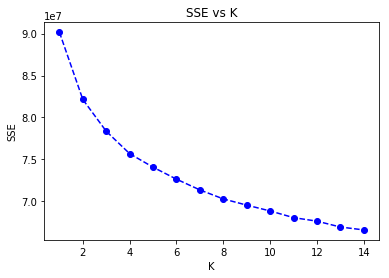

In [118]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle="--", marker="o", color="b");
plt.xlabel('K')
plt.ylabel('SSE')
plt.title("SSE vs K")

In [119]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_fin = KMeans(10, random_state=2)
model_fin = kmeans_fin.fit(X_pcaF)
pred_fin = model_fin.predict(X_pcaF)

### Discussion 3.1: Apply Clustering to General Population

I decided to use 10 cluster to segment the population. Based on the relationship (SSE vs K), the "elbow" occurs somewhere between a K of 5 and 10, and based on my assessment, becomes linear at K = 10.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [120]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

NaN Conversion Done!


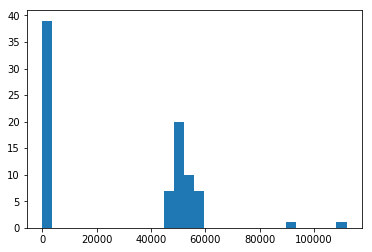

Outlier Missing Data Columns are:
['AGER_TYP', 'KK_KUNDENTYP']
Outlier columns removed. Shape is:
(191652, 83)
Outlier rows removed. Shape is:
(141711, 83)
OST_WEST_KZ replaced.
Categorical variables processed. New shape is:
(141711, 124)
decade feature generated.
movement feature generated.
wealth feature generated.
lifestage feature generated.
Dropping Mixed Categorical Variables:
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']
Mixed variables processed. New shape is:
(141711, 121)
False
True


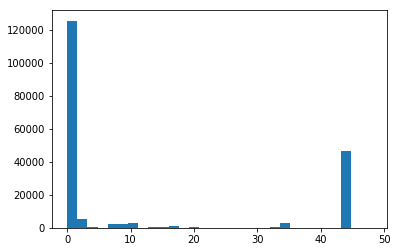

In [121]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_fin = clean_data(customers)

In [122]:
X_ss_C = ss.transform(customers_fin)

pcaF_C, X_pcaF_C = do_pca(75, X_ss_C)

# kmeans_fin_C = KMeans(10, random_state=30)
# model_fin_C = kmeans_fin_C.fit(X_pcaF_C)
# pred_fin_C = model_fin_C.predict(X_pcaF_C)
pred_fin_C = model_fin.predict(X_pcaF_C)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [123]:
def clusterDist(clusCounts, totalCounts):
    for clusNo, clusCount in clusCounts:
        print(str(clusNo) + " - {:.0%}".format(clusCount/totalCounts))

In [124]:
def plotClusters(pred_gen, pred_cust):
    fig, ax =plt.subplots(1,2)
    sns.countplot(pred_gen, ax=ax[0])
    sns.countplot(pred_cust, ax=ax[1])
    fig.show()

General Population Clusters:
0 - 10%
1 - 6%
2 - 7%
3 - 9%
4 - 11%
5 - 5%
6 - 10%
7 - 11%
8 - 11%
9 - 9%
Customer Population Clusters:
0 - 0%
1 - 28%
3 - 30%
5 - 5%
6 - 0%
7 - 11%
8 - 0%


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


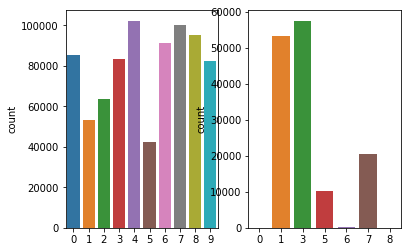

In [125]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Compute general population cluster proportions
y_gen = np.bincount(pred_fin)
ii_gen = np.nonzero(y_gen)[0]
clusCounts_gen = zip(ii_gen,y_gen[ii_gen])

totalCount_gen = len(pred_fin) + outClustCount_gen

print("General Population Clusters:")
clusterDist(clusCounts_gen, totalCount_gen)

# Compute customer cluster proportions
y_cust = np.bincount(pred_fin_C)
ii_cust = np.nonzero(y_cust)[0]
clusCounts_cust = zip(ii_cust,y_cust[ii_cust])
print(clusCounts_cust)

outClustCount_cust = 191652 - 141711
totalCount_cust = len(pred_fin_C) + outClustCount_cust

print("Customer Population Clusters:")
clusterDist(clusCounts_cust, totalCount_cust)

plotClusters(pred_fin, pred_fin_C)

In [126]:
from mpl_toolkits.mplot3d import Axes3D

def plot_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure();
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');

In [139]:
import copy

res = model_fin.__dict__

# print(res['cluster_centers_'][2])

clus2_sorted = copy.deepcopy(res['cluster_centers_'][2])
clus2_sorted_featNo = np.argsort(clus2_sorted)
clus2_sorted = np.sort(clus2_sorted)

print(clus2_sorted)
print(clus2_sorted_featNo)

# plot_data(X_pcaF_C, pred_fin_C)

[ -2.42507911e+00  -5.82269030e-01  -5.33820344e-01  -2.60355932e-01
  -2.09006708e-01  -1.79350798e-01  -1.59821260e-01  -1.50942861e-01
  -1.42192316e-01  -1.31734938e-01  -1.20230184e-01  -9.06059260e-02
  -8.70484764e-02  -7.84911936e-02  -7.78643272e-02  -7.29940567e-02
  -6.60365253e-02  -5.50698393e-02  -4.94010799e-02  -4.28335636e-02
  -4.24390246e-02  -4.11562219e-02  -3.76220400e-02  -3.57914920e-02
  -3.51497625e-02  -3.43939353e-02  -2.96231723e-02  -1.41084743e-02
  -9.77260759e-03  -9.34822032e-03  -8.33667640e-03  -8.28577850e-03
  -3.90734770e-03  -4.70454519e-04   1.18689785e-03   4.40209534e-03
   8.07846578e-03   1.11596499e-02   1.79150299e-02   2.01836243e-02
   2.13773689e-02   2.20298640e-02   2.46441546e-02   3.39568933e-02
   3.51272528e-02   3.58777558e-02   3.71786007e-02   4.49283444e-02
   5.38891551e-02   6.17425188e-02   6.19025279e-02   6.40649151e-02
   6.72588712e-02   7.05429874e-02   7.35061870e-02   8.16218325e-02
   8.45460736e-02   8.49366516e-02

### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?  

The second cluster (Cluster #1 in chart above) seems to be somewhat overrepresented in the customer dataset relative to the general population.  

When we dig into the weightings of the PCA features, the biggest positive predictors for this seems to be the First & Third PC (positive) and Second PC (negative). Going back to our interpretation in Section 2.3, we deemed these to be characterized by:  
1. Indicate consumers with less economic power in regions with higher densities of family homes. [Driven by positive First PC]  
2. Fairly gloom & introverted mindset (perhaps even anti-social) [Driven by positive Third PC]
3. Younger people who tend to be higher, flashier spenders with little that holds them back (e.g. tradition, religion, dutifulness) [Driven by negative Second PC]

In [140]:
clus0_sorted = copy.deepcopy(res['cluster_centers_'][0])
# print(clus0_sorted)
clus0_sorted_featNo = np.argsort(clus0_sorted)
clus0_sorted = np.sort(clus0_sorted)

print(clus0_sorted)
print(clus0_sorted_featNo)

[ -3.45855899e+00  -1.89470814e+00  -4.42099488e-01  -3.96302992e-01
  -3.96233700e-01  -2.77111891e-01  -2.65904614e-01  -1.53420003e-01
  -1.46987894e-01  -1.42112312e-01  -1.27674942e-01  -1.20997111e-01
  -1.08505957e-01  -1.03329205e-01  -9.01933814e-02  -8.45125440e-02
  -8.43198559e-02  -8.15481799e-02  -7.31674430e-02  -6.75406485e-02
  -6.31328338e-02  -6.24132295e-02  -6.19502552e-02  -5.73856491e-02
  -5.46702019e-02  -4.37799849e-02  -4.31236594e-02  -4.06958630e-02
  -3.34556795e-02  -3.17651364e-02  -2.91806894e-02  -2.45797076e-02
  -2.33937663e-02  -2.27751979e-02  -1.97188304e-02  -1.67124396e-02
  -1.20743945e-02  -7.44547648e-03  -3.51834676e-03  -5.16289855e-04
   5.45918553e-03   7.79817623e-03   7.89215321e-03   1.32204213e-02
   1.39024441e-02   1.66207721e-02   2.30930443e-02   2.37336085e-02
   2.40438263e-02   2.59603758e-02   2.60890293e-02   2.74317699e-02
   2.82272603e-02   4.19566202e-02   5.10923734e-02   5.15658202e-02
   5.85493723e-02   5.99868562e-02

### What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

The first cluster (Cluster 0 in above chart) seems to be underrepresented in the customer data relative to the general population, implying that this cluster of the general population is most likely not a target segment for our client's mail-order campaigns.
1. First PC (negative) - Live in areas with a high share of 1-2 family homes (less densely populated).
2. Third PC (positive) - Fairly gloom & introverted mindset (perhaps even anti-social).

### Discussion 3.3: Compare Customer Data to Demographics Data

Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?  

Our analysis helps us describe segments of the population that are relatively popular & unpopular with the company. Those that are heavily represented in the customer da Specifically:  

**1. Popular**  
Consumers with medium-to-low economic power in densely populated regions (most likely bigger cities), with a fairly gloom/introverted mindset, with high spending habits.

**2. Unpopular**  
Consumers with fairly gloom & introverted mindsets 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.